In [159]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, RocCurveDisplay, roc_curve, auc

# Chicago Car Crash Analysis

## Overview 
add overview 

## Business Problem

add buisness problem

## Data Source 

Car crash and vehicle accident data was sourced from the [Chicago Data Portal](https://data.cityofchicago.org/Transportation/Traffic-Crashes-People/u6pd-qa9d/about_data). It originates from the [City of Chicago](http://www.chicago.gov/)

Data collection began in 2015, but was only adopted by all police departments in 2017. The most recent data entry was from September 26, 2024. 

## Results

add results

# Data Import and Cleaning 

In [ ]:
df_vehicles = pd.read_csv("data/Traffic_Crashes_Vehicles.csv")
df_people = pd.read_csv("data/Traffic_Crashes_People.csv")
df_crashes = pd.read_csv("data/Traffic_Crashes_Crashes.csv")

## Merge Dataframes

First we sample 300,000 crash reports, then we merge the vehicle and people involved. 

In [3]:
#Random sample of vehicles 
df_accidents = df_vehicles.sample(n=300000, random_state=42)

In [ ]:
df_accidents.info()

In [5]:
#Then we can add the crash report data 
df_accidents = df_accidents.merge(df_crashes, how="inner", on=["CRASH_RECORD_ID", "CRASH_DATE"])

In [ ]:
df_accidents.info()

In [7]:
#every person and vehicle should have a match for the record ID, vehicle ID, and crash date
#This makes the dataframe larger as multiple people are involved in each accident 
df_accidents = df_accidents.merge(df_people, how="inner", on=["CRASH_RECORD_ID", "VEHICLE_ID", "CRASH_DATE"])

In [ ]:
df_accidents.info()

The dataframe gets larger when merging in the people, as there are sometimes more than one person involved in an accident.  

# THIS IS FOR WORKING PURPOSES. 

# USE THIS TO IMPORT DF WITHOUT RUNNING THE CELLS ABOVE.

## Export Final

In [13]:
df_accidents.to_csv('data/Final_Data.csv')

## Read Final

In [161]:
df_accidents = pd.read_csv("data/Final_Data.csv")

/var/folders/4f/cr2zm2px70q9hrgj23zmw7_r0000gn/T/ipykernel_32274/2274169522.py:1: DtypeWarning: Columns (19,21,40,41,42,44,48,49,50,55,58,59,61,71,102,123,143) have mixed types. Specify dtype option on import or set low_memory=False.
  df_accidents = pd.read_csv("data/Final_Data.csv")


# ^^^^^ DELETE BEFORE SUBMISSION

In [162]:
#have the crash date as a datetime object. 
df_accidents['CRASH_DATE'] = pd.to_datetime(df_accidents['CRASH_DATE'], format="%d%m%Y %I:%M:%S %p")

df_accidents.info()

ValueError: time data "05/24/2022 08:23:00 PM" doesn't match format "%d%m%Y %I:%M:%S %p", at position 0. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

## Drop Unnessisary Columns

In [163]:
#remove columns with less than 50% of data present 
df_accidents.dropna(axis=1, thresh = int(0.5*df_accidents.shape[0]), inplace=True)

In [164]:
cols_to_drop = [
#remove unessisary id columns now the data is joined 
'VEHICLE_ID', 'CRASH_RECORD_ID', 'CRASH_UNIT_ID',
#drop LAT and LONG (we have location)
'LATITUDE', 'LONGITUDE',
#...also drop streets and directions. 
'STREET_NO', 'STREET_DIRECTION', 'STREET_NAME', 'TRAVEL_DIRECTION', 
#police specific 
'BEAT_OF_OCCURRENCE', 
#everything is chicago 
'CITY', 'ZIPCODE', 
#covered by MOST_SEVERE_INJURY
'INJURY_CLASSIFICATION',
#many NAN
'INJURIES_UNKNOWN'
]

df_accidents.drop(columns=cols_to_drop, inplace=True)


In [165]:
#map the injuries to a number 

def weather_code(weather):
    """
    Codes are based on https://openweathermap.org/weather-conditions
    0 - Unknown 
    500 - Rain
    600 - Snow
    700 - 'Atmosphere' (Fog, Dust, Haze) 
    800 - Clear
    801 - Clouds 

    """
    if weather == 'CLEAR':
        return 800
    elif weather == 'CLOUDY/OVERCAST':
        return 801
    elif weather == 'RAIN':
        return 500
    elif weather == 'SNOW' or weather == 'FREEZING RAIN/DRIZZLE' or weather== 'SLEET/HAIL' or weather == 'BLOWING SNOW':
        return 600
    elif weather == 'FOG/SMOKE/HAZE' or weather == 'BLOWING SAND/SOIL/DIRT':
        return 700
    else:
        return 0
    
df_accidents['WEATHER_CONDITION'] = df_accidents['WEATHER_CONDITION'].map(weather_code)

In [166]:
#map the injuries to a number 

def injury_severity(severity):
    """
    Injuties are categorized on a scale of 0 to X
    0 - No Indication of Injury 
    1 - REPORTED, NOT EVIDENT 
    2 - NONincapacitating Injury 
    3 - incapacitating Injury 
    4 - Fatal Injury 
    """
    if severity == 'NO INDICATION OF INJURY':
        return 0
    elif severity == 'REPORTED, NOT EVIDENT':
        return 1
    elif severity == 'NONINCAPACITATING INJURY':
        return 2
    elif severity == 'INCAPACITATING INJURY':
        return 3
    elif severity == 'FATAL':
        return 4
    else:
        return 0
    

df_accidents['INJURY_CLASS'] = df_accidents['MOST_SEVERE_INJURY'].map(injury_severity)

In [167]:
#map the injuries to a number 

def crash_severity(severity):
    """
    Injuties are categorized on a scale of 0 to X
    0 - No Injury / Drive Away 
    1 - Injury and / or tow  
    """
    if severity == 'NO INJURY / DRIVE AWAY':
        return 0
    else:
        return 1
    

df_accidents['CRASH_TYPE'] = df_accidents['CRASH_TYPE'].map(crash_severity)

In [168]:
#drop the columns 
in_cols_to_drop = [
#remove counts of each injury 
'INJURIES_FATAL', 'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING',
'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION'
]

df_accidents.drop(columns=in_cols_to_drop, inplace=True)

In [169]:
count = 0
for column in df_accidents.iloc[0]:
    print(df_accidents.columns[count], ":", column, ",", df_accidents.iloc[1].iloc[count])
    count += 1

Unnamed: 0 : 0 , 1
CRASH_DATE : 05/24/2022 08:23:00 PM , 09/28/2019 01:45:00 PM
UNIT_NO : 1 , 2
UNIT_TYPE : DRIVER , DRIVER
MAKE : TOYOTA , VOLKSWAGEN
MODEL : CAMRY , JETTA
LIC_PLATE_STATE : IL , IL
VEHICLE_YEAR : 2018.0 , 2012.0
VEHICLE_DEFECT : UNKNOWN , UNKNOWN
VEHICLE_TYPE : PASSENGER , PASSENGER
VEHICLE_USE : PERSONAL , PERSONAL
MANEUVER : TURNING LEFT , STRAIGHT AHEAD
OCCUPANT_CNT : 1.0 , 1.0
FIRST_CONTACT_POINT : FRONT , ROOF
POSTED_SPEED_LIMIT : 30 , 20
TRAFFIC_CONTROL_DEVICE : STOP SIGN/FLASHER , NO CONTROLS
DEVICE_CONDITION : FUNCTIONING PROPERLY , NO CONTROLS
WEATHER_CONDITION : 800 , 800
LIGHTING_CONDITION : DUSK , DAYLIGHT
FIRST_CRASH_TYPE : PEDALCYCLIST , SIDESWIPE OPPOSITE DIRECTION
TRAFFICWAY_TYPE : FOUR WAY , OTHER
ALIGNMENT : STRAIGHT AND LEVEL , STRAIGHT AND LEVEL
ROADWAY_SURFACE_COND : DRY , DRY
ROAD_DEFECT : NO DEFECTS , UNKNOWN
REPORT_TYPE : ON SCENE , NOT ON SCENE (DESK REPORT)
CRASH_TYPE : 1 , 0
DAMAGE : $500 OR LESS , OVER $1,500
DATE_POLICE_NOTIFIED : 05/24/20

In [170]:
matrix = df_accidents.corr(numeric_only=True)
print(matrix)

                    Unnamed: 0   UNIT_NO  VEHICLE_YEAR  OCCUPANT_CNT  \
Unnamed: 0            1.000000 -0.000147      0.000440      0.005952   
UNIT_NO              -0.000147  1.000000     -0.007320      0.103042   
VEHICLE_YEAR          0.000440 -0.007320      1.000000     -0.004234   
OCCUPANT_CNT          0.005952  0.103042     -0.004234      1.000000   
POSTED_SPEED_LIMIT    0.001071  0.073894     -0.000297      0.029766   
WEATHER_CONDITION     0.004400  0.030809     -0.001856      0.034301   
CRASH_TYPE           -0.000479  0.061903     -0.005193      0.090895   
NUM_UNITS             0.000013  0.276457     -0.000940      0.016165   
INJURIES_TOTAL       -0.004392  0.112213     -0.003746      0.193060   
CRASH_HOUR            0.003331  0.040057      0.001082     -0.001259   
CRASH_DAY_OF_WEEK     0.002641  0.009996      0.001206      0.001301   
CRASH_MONTH          -0.001284  0.007062     -0.003140     -0.001107   
AGE                  -0.002107  0.020860     -0.004818     -0.19

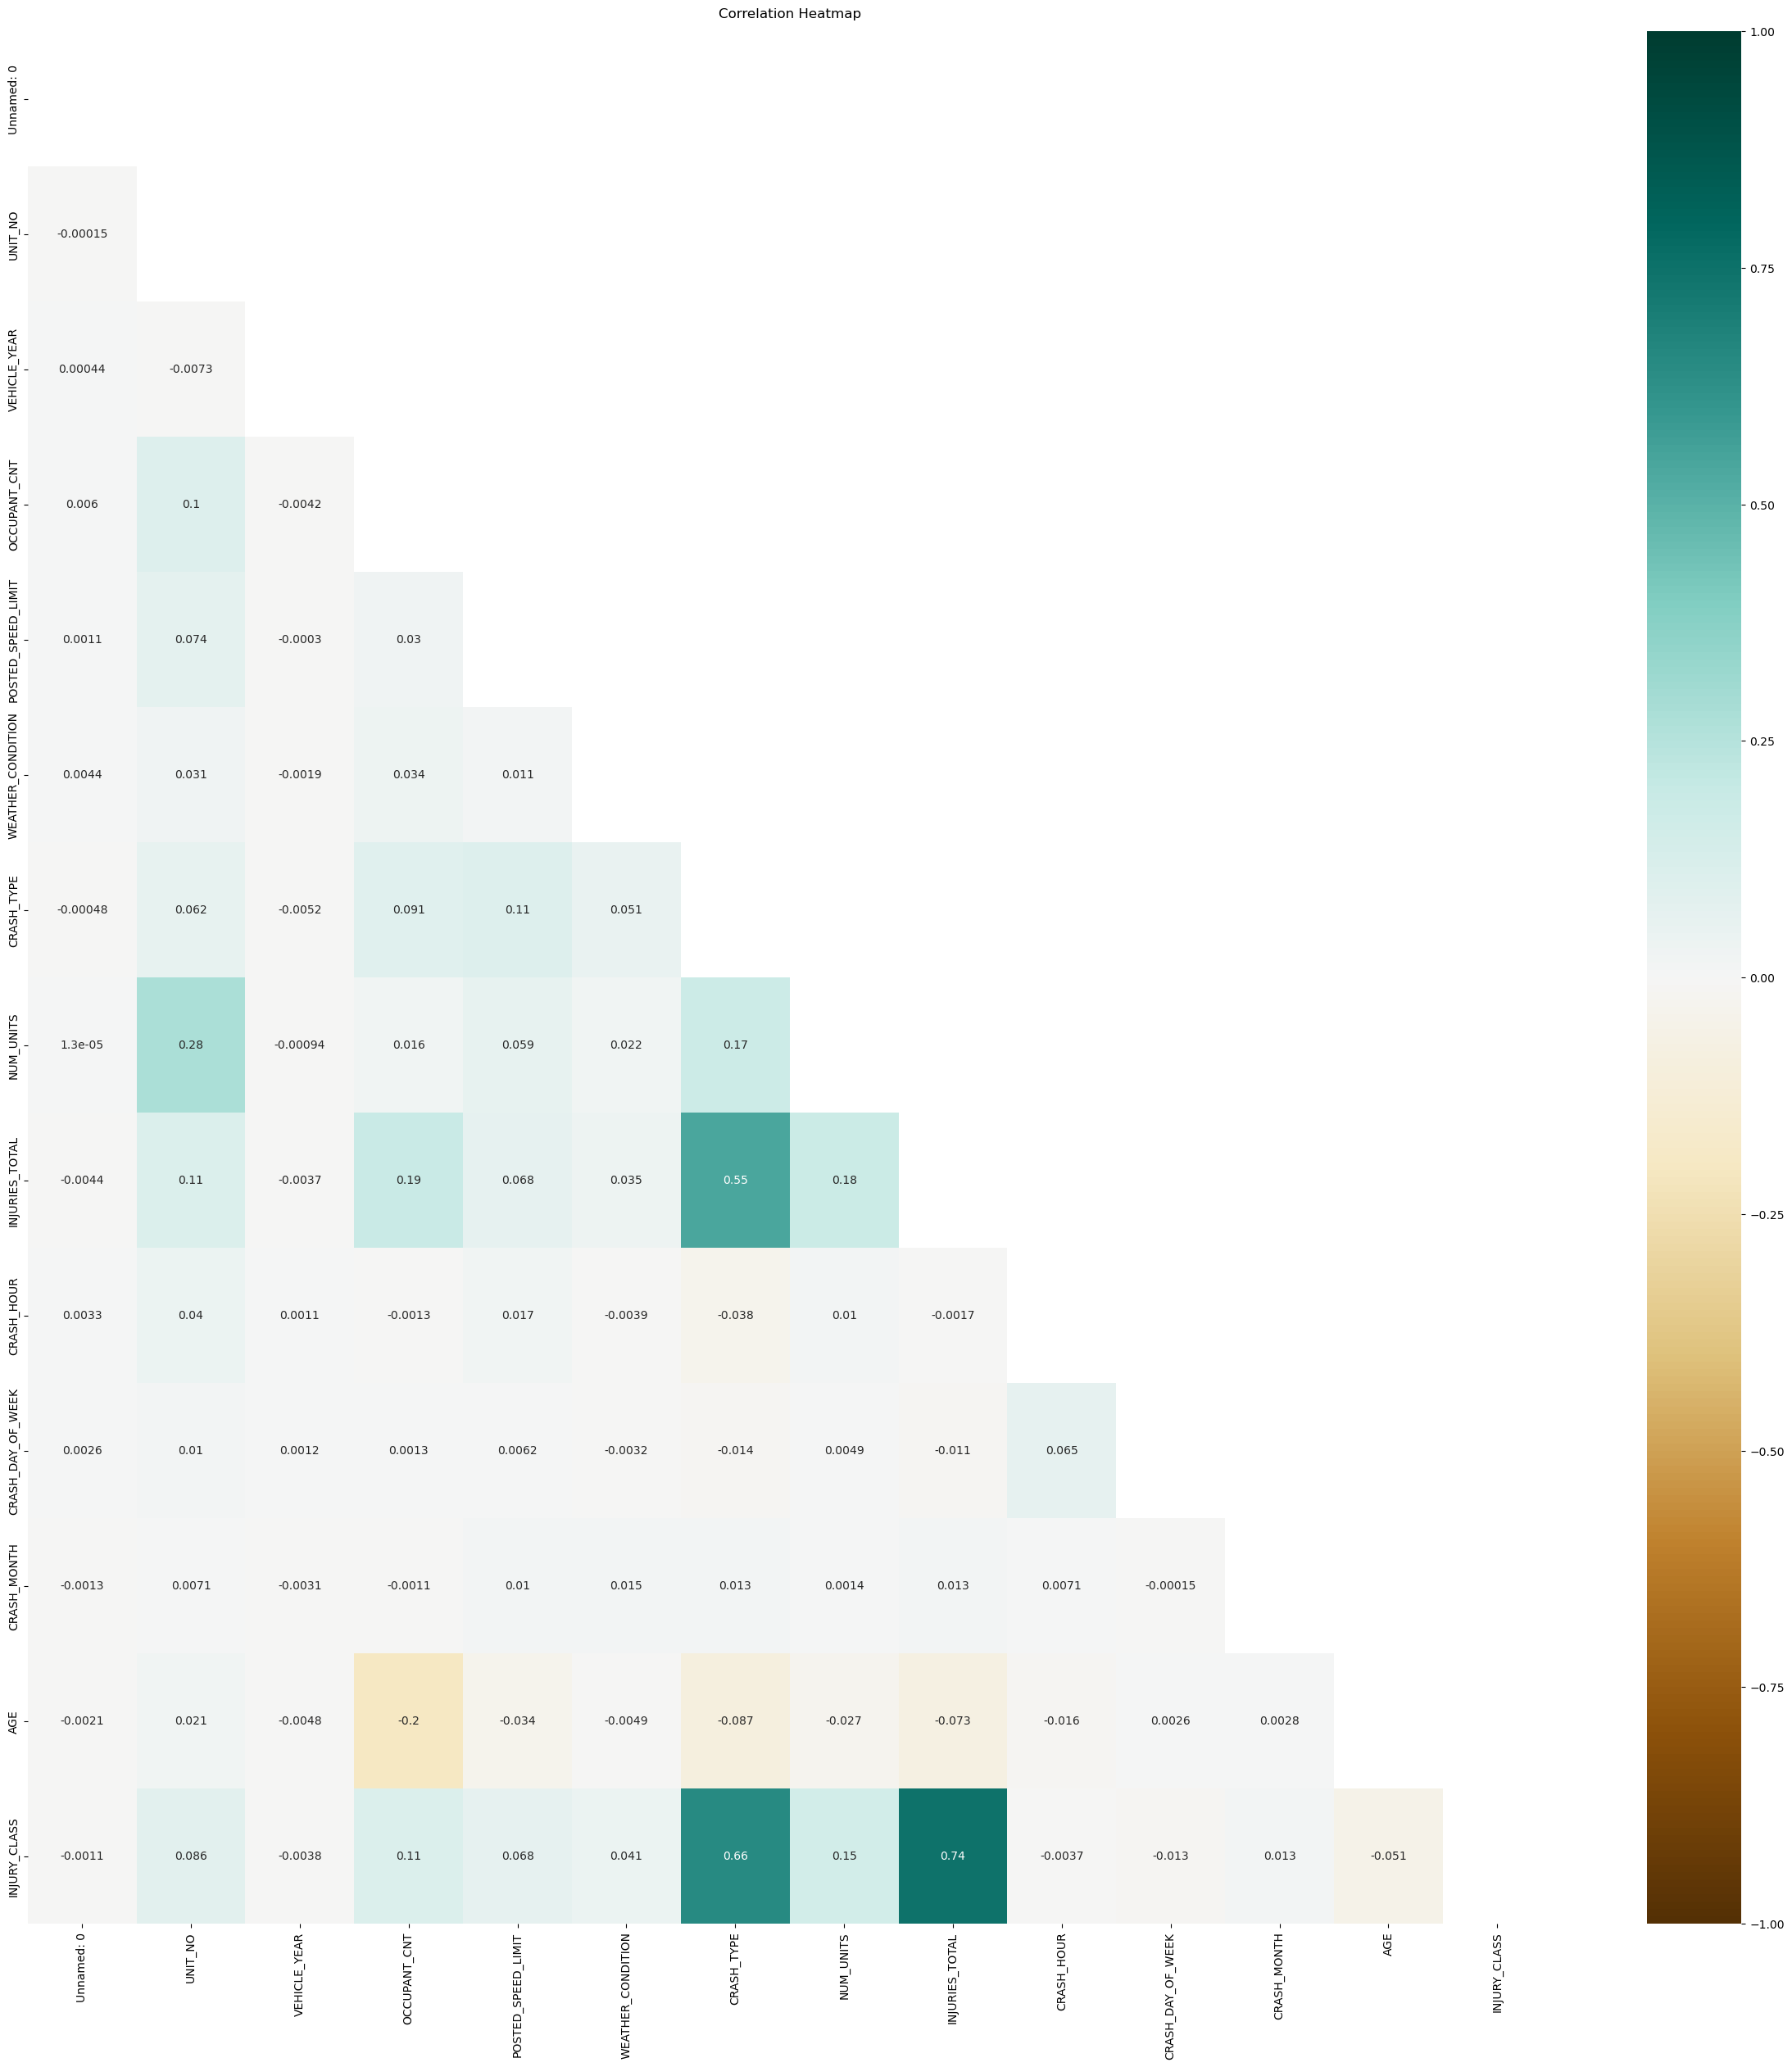

In [171]:
plt.figure(figsize=(30, 30))

#create a mask to remove the duplicate upper half
mask = np.triu(np.ones_like(matrix, dtype=np.bool))

heatmap = sns.heatmap(matrix, vmin=-1, mask=mask, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

Use a Decsicion Tree model to determine importaint categories. 

### DT

# EDA

figures?

## Combine Columns into Categories 

In [17]:
#py

## Train Test Split

# Model 1

Justification of Model 1

Conclusions from model 1.

# Model 2

Justification of Model 2

Conclusions from model 1.

# Conclusions 

# Next Steps